In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'

In [2]:
# Load wrangled data saved in .csv files for scheduling experiment sessions
sch_sessions = pd.read_csv('data/scheduler/sessions.csv', index_col=0)
sch_pilots = pd.read_csv('data/scheduler/pilots.csv', index_col=0)
sch_units = pd.read_csv('data/scheduler/units.csv', index_col=0)

In [3]:
print 'Scheduler: Total number of experiments: %s' % sch_sessions['experiment'].shape[0]
print 'Scheduler: Total number of successful runs: %s' % sch_sessions.shape[0]
print 'Scheduler: Total number of pilots: %s' % sch_pilots.shape[0]
print 'Scheduler: Total number of units: %s\n' % sch_units.shape[0]

Scheduler: Total number of experiments: 3
Scheduler: Total number of successful runs: 3
Scheduler: Total number of pilots: 3
Scheduler: Total number of units: 2560



In [4]:
sch = sch_sessions[
    ['experiment',
     'nunit',
     'TTC',
     'P_LRMS_QUEUING',
     'U_AGENT_QUEUING',
     'U_AGENT_SCHEDULING',
     'U_AGENT_QUEUING_EXEC',
     'U_AGENT_EXECUTING']
        ].groupby(['experiment','nunit']).agg(
                {'TTC'                 : ['mean','std'],
                 'P_LRMS_QUEUING'      : ['mean','std'],
                 'U_AGENT_QUEUING'     : ['mean','std'],
                 'U_AGENT_SCHEDULING'  : ['mean','std'],
                 'U_AGENT_QUEUING_EXEC': ['mean','std'],
                 'U_AGENT_EXECUTING'   : ['mean','std']})

# Rename columns for readibility
sch.rename({'P_LRMS_QUEUING'      :'TTQ'}, axis='columns', inplace=True)
sch.rename({'U_AGENT_QUEUING'     :'Agent queueing'}, axis='columns', inplace=True)
sch.rename({'U_AGENT_SCHEDULING'  :'Agent scheduling'}, axis='columns', inplace=True)
sch.rename({'U_AGENT_QUEUING_EXEC':'Agent queueing execution'}, axis='columns', inplace=True)
sch.rename({'U_AGENT_EXECUTING'   :'TTX'}, axis='columns', inplace=True)
sch.rename(index={i[1]: '%s/%s' % (i[1], i[1]*32) for i in sch.index.get_values()}, inplace=True, level=1)
sch

TTQ     Agent queueing     Agent queueing execution            TTX               TTC     Agent scheduling    
                             mean std           mean std                     mean std       mean std          mean std             mean std
experiment nunit                                                                                                                           
exp1       256/8192    23676.0705 NaN        11.0161 NaN                 4.835300 NaN  1316.2753 NaN  2.507315e+04 NaN         3.176800 NaN
exp2       256/8192     1022.3516 NaN        13.9417 NaN                 0.515802 NaN  1053.3465 NaN  1.540692e+09 NaN         4.412299 NaN
exp3       2048/65536   8623.3539 NaN       124.2952 NaN                61.680899 NaN  1342.4023 NaN  1.540699e+09 NaN        99.525200 NaN

In [5]:
import sys
import pprint

import matplotlib.pyplot as plt
import numpy             as np

import radical.utils     as ru
import radical.pilot     as rp
import radical.analytics as ra

from   radical.utils.profile import *
from   radical.pilot.states  import *

UNIT_DURATIONS = {
        'exec-tot' : [{STATE: AGENT_EXECUTING,              EVENT: 'state'        },
                      {STATE: AGENT_STAGING_OUTPUT_PENDING, EVENT: 'state'        }],
        'exec-rp'  : [{STATE: None,                         EVENT: 'exec_start'   },
                      {STATE: None,                         EVENT: 'exec_stop'    }],
        'exec-cu'  : [{STATE: None,                         EVENT: 'cu_start'     },
                      {STATE: None,                         EVENT: 'cu_exec_stop' }],
        'exec-orte': [{STATE: None,                         EVENT: 'cu_exec_start'},
                      {STATE: None,                         EVENT: 'cu_exec_stop' }],
        'exec-app' : [{STATE: None,                         EVENT: 'app_start'    },
                      {STATE: None,                         EVENT: 'app_stop'     }]}

data    = dict()
sch_path = '../rawdata/scheduling/'

sources = ['%s/rp.session.titan-ext1.merzky1.017832.0006' % sch_path,
           '%s/rp.session.titan-ext1.merzky1.017832.0007' % sch_path]

for dname in UNIT_DURATIONS:
    data[dname]  = list()

# get the numbers we actually want to plot
fout = open('outliers.dat', 'w')
ucnt = 0
ocnt = 0
for src in sources:
    # always point to the tarballs
    if src[-4:] != '.tbz':
        src += '.tbz'

#     print
#     print '-----------------------------------------------------------'
#     print src

    session = ra.Session(src, 'radical.pilot')
    units   = session.filter(etype='unit', inplace=True)
    sid     = session.uid

    for unit in units.get():
        for dname in UNIT_DURATIONS:
            dur = unit.duration(event=UNIT_DURATIONS[dname])
            if dur > 1000.0:
                ocnt += 1
                fout.write('%10.1f  %s\n' % (dur, src))
                fout.flush()
#                 sys.stdout.write('#')
            else:
                ucnt += 1
                data[dname].append(dur)
#                 sys.stdout.write('.')
            sys.stdout.flush()

conflicting time sync for bootstrap_0.prof                              (titan-batch3.ccs.ornl.gov:10.128.36.164):      -0.18 -      -4.77 =  4.59
conflicting time sync for agent_0.prof                                  (titan-batch3.ccs.ornl.gov:10.128.36.164):      -0.18 -      -4.77 =  4.59
conflicting time sync for agent_0.prof                                  (titan-batch3.ccs.ornl.gov:10.128.36.164):      -0.04 -      -4.77 =  4.73
conflicting time sync for agent_0.staging.input.0.prof                  (titan-batch3.ccs.ornl.gov:10.128.36.164):      -0.01 -      -4.77 =  4.76
conflicting time sync for agent_0.staging.output.0.prof                 (titan-batch3.ccs.ornl.gov:10.128.36.164):      -0.02 -      -4.77 =  4.75
conflicting time sync for agent_0.staging.input.0.child.prof            (titan-batch3.ccs.ornl.gov:10.128.36.164):      -0.02 -      -4.77 =  4.75
conflicting time sync for update.0.child.prof                           (titan-batch3.ccs.ornl.gov:10.128.36.164):    

/Users/mturilli/Virtualenvs/experiments/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


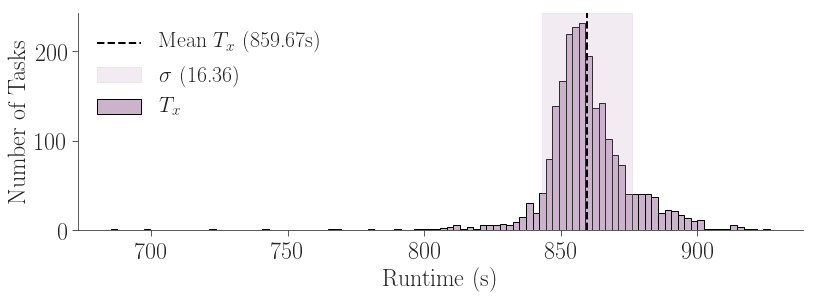

In [6]:
fig, ax = fig_setup(figsize=(13,4))

data_mean = np.mean(data['exec-app'])
data_sigma = np.sqrt(np.var(data['exec-app']))

ax.hist(data['exec-app'], bins=100, color=tableau20[9])#, histtype='step')
ax.axvline(x=data_mean, color='black', linestyle='dashed')
ax.axvspan(data_mean-data_sigma, data_mean+data_sigma, alpha=0.25, color=tableau20[9])

ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Number of Tasks')
ax.legend(['Mean $T_x$ (%ss)' %  round(data_mean, 2), 
           '$\sigma$ (%s)'    % round(data_sigma, 2), 
           '$T_x$'])

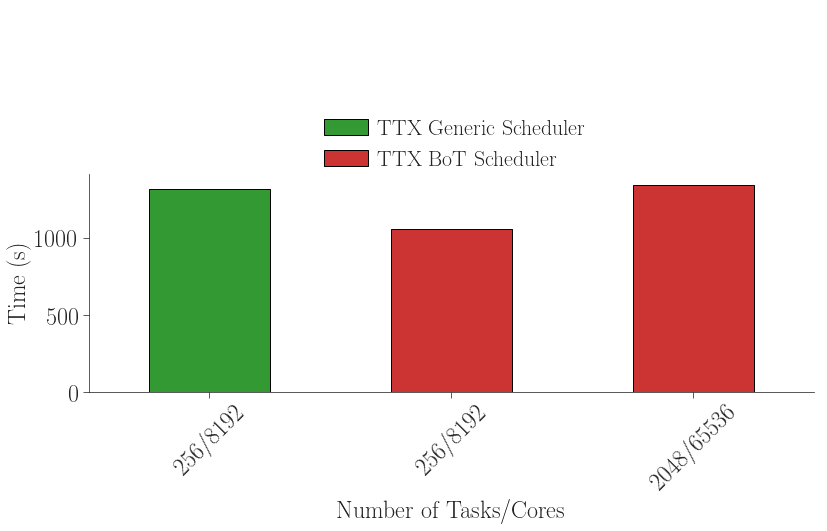

In [7]:
fig, ax = fig_setup(figsize=(13,4))

# sch[sch.index.isin(['exp1'], level='experiment')]['TTX'].reset_index().plot.bar(
#         x='nunit', y='mean', yerr='std', 
#         width=0.5, color=tableau20[4], ax=ax, rot=45, legend=False)

ax1 = sch['TTX'].reset_index().plot.bar(
        x='nunit', y='mean', yerr='std', 
        width=0.5, color=[tableau20[4], tableau20[6],tableau20[6]], ax=ax, rot=45, legend=False)

# ax1.axhline(y=np.mean(data['exec-app']), lw=1.5, color='black', ls='dashed')

ax.set_xlabel('Number of Tasks/Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0)
ax.set_xlim(-0.5)

fig.legend(
            (mpl.patches.Patch(facecolor=tableau20[4]),
             mpl.patches.Patch(facecolor=tableau20[6])
             # mpl.lines.Line2D([], [], color='black', linestyle='dashed')
            ),
            ('TTX Generic Scheduler', 'TTX BoT Scheduler'), 
            'upper left',
            columnspacing=0.75,
            handletextpad=0.4,
            # bbox_to_anchor=(0.1175, 1.265)
            bbox_to_anchor=(0.325, 1.5)
          )